In [1]:
import hypernetx as hnx
import matplotlib as mp
import matplotlib.pyplot as plt
import networkx as nx
import qf.cc
import qf.graphs
import qf.morph
import numpy as np
import tempfile
import libsbml
from IPython.display import Image
%matplotlib inline

In [2]:
def add_directed_hyperedge(H, sources, target, name=None):
    """
    Adds a directed hyperarc to the hypergraph H. The corresponding edge has all sources (a list of nodes)
    and target as endpoints. The special property 'target' is associated with the edge, whose value is the target.
    
    Args:
        H: a `hypernetx.Hypergraph`.
        sources: a list containing the source nodes.
        target: the target node.
        name: name of the hyperarc.
    """
    if name is None:
        name = H.number_of_edges()
    H.add_edge(hnx.Entity(name, sources + [target], props={'target': target}))

def add_directed_hyperedges(H, stpairs):
    """
    Adds a list directed hyperarcs, each specified as a pair (sources, target[, name]).
    
    Args:
        H: a `hypernetx.Hypergraph`.
        stpairs: a list containing the arcs to be added, each specified by a pair or triple (the first element
        being a list of sources and the target being the target). The third element, if present, is the name
        of the hyperarc.
    """
    for st in stpairs:
        if len(st) == 2:
            add_directed_hyperedge(H, st[0], st[1])
        else:
            add_directed_hyperedge(H, st[0], st[1], name=st[2])


In [3]:
def hg2g(H):
    """
    Returns the RB-graph representation of a hypergraph.
    
    Args:
        H: a `hypernetx.Hypergraph`, all of whose hyperedges contain a target propery, that contains the target node.
        
    Returns:
        - the graph.
        - a dictionary mapping the nodes of the returned graph to 0 (blue nodes, i.e., nodes of H) or to 1 (red nodes, i.e., hyperarcs of H).
    """
    G = nx.MultiDiGraph()
    G.add_nodes_from([x.uid for x in H.nodes()])
    G.add_nodes_from([x.uid for x in H.edges()])
    dd1 = {x.uid: 0 for x in H.nodes()} # Blue nodes
    dd2 = {x.uid: 1 for x in H.edges()} # Red nodes
    dd = {**dd1, **dd2}
    for h in H.edges():
        target = h.props['target']
        for i,e in enumerate(h.elements):
            if e != target:
                G.add_edge(e, h.uid, label='(%s,%d,%s)' % (e, i, h.uid))
            else:
                G.add_edge(h.uid, e, label='(%s,%s)' % (h.uid, e))
    return G, dd

In [49]:
posDict = {}

def _visualize_hg(H, png_filename, colors = None):
    """
        Saves a given hypergraph onto a given PNG file. Internal use only.
        
        Args:
            H: a `hypernetx.Hypergraph`, all of whose hyperedges contain a target propery, that contains the target node.
            png_filename: the name of the PNG file to be saved.
            colors: a dictionary of colors (i.e., values for each node; same value imply same color).
    """
    if colors is None:
        col1 = {v.uid: 0 for v in H.nodes()} 
        col2 = {h.uid: 0 for h in H.edges()}
        colors = {**col1, **col2}
    ncols = max(set(colors.values()))+1 
    cols = np.vstack([[0,0,0,1],plt.cm.tab10(np.arange(40))]) # 0 is black
    plt.ioff()
    fig, ax = plt.subplots()
    if H in posDict:
        posnodes = posDict[H]
    else:
        posnodes = hnx.drawing.rubber_band.layout_node_link(H)
        posDict[H] = posnodes
    hnx.drawing.draw(H, 
                 pos = posnodes, ax=ax,
                 with_edge_labels=False,
                 edges_kwargs={
                     'edgecolors': [cols[colors[h.uid]] for h in H.edges()]
                 },
                 nodes_kwargs={
                     'facecolors': [cols[colors[v.uid]] for v in H.nodes()]
                 }
                )
    for h in H.edges():
        target = h.props['target']
        xtarget = posnodes[target][0]
        ytarget = posnodes[target][1]
        for e in h.elements:
            if e != target:
                xsource = posnodes[e][0]
                ysource = posnodes[e][1]
                dx = xtarget - xsource
                dy = ytarget - ysource
                ax.arrow(xsource, ysource, dx, dy, head_width=.03, head_length=.03, 
                         length_includes_head=True, color=cols[colors[h.uid]])
    plt.savefig(png_filename, format="PNG")

def visualize_hg(H, colors = None):
    """
        Visualizes a given hypergraph.
        
        Args:
            H: a `hypernetx.Hypergraph`, all of whose hyperedges contain a target propery, that contains the target node.
            colors: a dictionary of colors (i.e., values for each node; same value imply same color).
    """
    png_filename = tempfile.NamedTemporaryFile(suffix=".png").name
    _visualize_hg(H, png_filename, colors = colors)
    return Image(filename=png_filename)

def save_hg(H, png_filename, colors = None):
    """
        Saves a given hypergraph onto a given PNG file.
        
        Args:
            H: a `hypernetx.Hypergraph`, all of whose hyperedges contain a target propery, that contains the target node.
            png_filename: the name of the PNG file to be saved.
            colors: a dictionary of colors (i.e., values for each node; same value imply same color).
    """
    _visualize_hg(H, png_filename, colors = colors)

In [50]:
def hyper_cardon_crochemore(H, nodes_only=False):
    """
        Performs naive vertex refinement on the hypegraph H. 
        
        Args:
            H: the hypergraph.
            nodes_only: if set, only nodes of the hypergraph are considered.
            
        Returns:
            a dictionary whose keys are the nodes (and possibly the hyperarcs) of H, and where two keys 
            are in the same equivalence class iff they have the same value. Note that node classes and
            hyperarc classes are always disjoint.
    """
    G, dd = hg2g(H)
    cc = qf.cc.cardon_crochemore(G, starting_label=dd)
    if nodes_only:
        for x in G.nodes():
            if dd[x] == 1:
                del cc[x]
    return cc

In [51]:
import csv

def read_hg_from_csv(filename, max_lines = -1):
    """
        Reads and returns a hypergraph from a CSV file. The file contains one triple per line,
        where the first two elements are the sources and the last element is the target.
        
        Args:
            filename: the name of the CSV file.
            max_lines: stop after reading this number of lines (-1 for all).
            
        Returns:
            a hypergraph
    """
    H = hnx.Hypergraph()
    n = 0
    with open(filename) as f:
        reader = csv.reader(f)
        for triple in reader:
            if max_lines >= 0 and n >= max_lines:
                break        
            add_directed_hyperedge(H, [triple[0], triple[1]], triple[2])
            n += 1
    return H

In [52]:
def read_hg_from_S(filename):
    """
        Reads an S-matrix file into a hypergraph. The first line of the file contains the names of the hyperarcs (the first entry should be ignored).
        The remaining lines contain as first element the name of a node, while the remaining entries are numbers:
        "1" is interpreted as the node being a source of the hyperarc; "-1" is interpreted as the node being a
        target; "0" is interpreted as the node not involved in the hyperarc; any other value is ignored.
        Hyperarcs remaining with no source or no target are ignored.
        
        Args:
            filename: the name of the file to be read.
            
        Returns:
            the hypergraph.
    """
    H = hnx.Hypergraph()
    sources = {}
    targets = {}
    with open(filename) as f:
        reader = csv.reader(f)
        hyperarcNames = next(reader)[1:]
        for a in hyperarcNames:
            sources[a] = []
            targets[a] = []
        for line in reader:
            nodeName = line[0]
            for i in range(1, len(line)):
                if float(line[i]) == +1:
                    sources[hyperarcNames[i - 1]] += [nodeName]
                elif float(line[i]) == -1:
                    targets[hyperarcNames[i - 1]] += [nodeName]
                elif float(line[i]) != 0:
                    print("Ignoring value ", line[i])
    for a in hyperarcNames:
        if len(sources[a]) == 0:
            print(a, " has no sources")
            continue
        if len(targets[a]) == 0:
            print(a, " has no targets")
            continue
        if len(targets[a]) == 1:
            add_directed_hyperedge(H, sources[a], targets[a][0], a)
        else:
            for i,t in enumerate(targets[a]):
                add_directed_hyperedge(H, sources[a], t, a + "_" + str(i))
    return H

In [53]:
def read_hg_from_SBML(filename):
    """
        Reads an SBML file into a hypergraph. This hypergraph contains one group of hyperarcs for every reaction,
        where reactants are the sources, and product(s) are the target(s). If there is more than one product,
        many hyperarcs are added, and their names are of the form "R_k" where "R" is the reaction id and
        "k" is the number identifying the subreaction so generated.
        
        Args:
            filename: the name of the file to be read.
            
        Returns:
            H: the hypergraph.
            sr2r: a dictionary that maps hyperarc names to reactions (i.e., reaction ids): for reactions R with just product, the 
                dictonary will contain a key equal to R, with associated value also equal to R; for
                reactions with n products, the dictionary will contain keys R_0,R_1,... and value R.
            r2ss: a dictionary that maps reactions to subsystems.
            rid2rname: a dictionary mapping reaction ids to reaction names.
            mid2mname: a dictionary mapping metabolites (i.e., species, in the SBML jargon) id to metabolites names.
    """

    H = hnx.Hypergraph()
    r2ss = {}
    sr2r = {}
    rid2rname = {}
    mid2mname = {}
    document = libsbml.readSBMLFromFile(filename)
    model = document.getModel()
    for species in model.getListOfSpecies():
        mid2mname[species.id] = species.name
    for i in range(model.getNumReactions()):
        reaction = model.getReaction(i)
        reactionId = reaction.id
        rid2rname[reactionId] = reaction.name
        notes = reaction.getNotes()
        numNotes = notes.getNumChildren()
        for nn in range(numNotes):
            if notes.getChild(nn).getChild(0).toString().startswith("SUBSYSTEM:"):
                r2ss[reactionId] = notes.getChild(nn).getChild(0).toString().split(": ")[1]
        reactantsIds = [p.species for p in reaction.getListOfReactants()]
        productsIds = [p.species for p in reaction.getListOfProducts()]
        numProducts = len(productsIds)
        numReactants = len(reactantsIds)
        if numProducts > 1:
            for np, product in enumerate(productsIds):
                add_directed_hyperedge(H, reactantsIds, product, reactionId + "_" + str(np))
                sr2r[reactionId + "_" + str(np)] = reactionId
        elif numProducts == 1:
            add_directed_hyperedge(H, reactantsIds, productsIds[0], reactionId)
            sr2r[reactionId] = reactionId
        else:
            print("Ignoring reaction ", reactionId, " because it has no products")
        if reaction.reversible:
            if numReactants > 1:
                for nr, reactant in enumerate(reactantsIds):
                    add_directed_hyperedge(H, productsIds, reactant, reactionId + "_R" + str(nr))
                    sr2r[reactionId + "_R" + str(nr)] = reactionId
            elif numReactants == 1:
                sr2r[reactionId + "_R"] = reactionId
                add_directed_hyperedge(H, productsIds, reactantsIds[0], reactionId + "_R")
    return H, sr2r, r2ss, rid2rname, mid2mname

In [56]:
def showMapKeys(m, onlyNonTrivial = True, keyadj = None, keydesc = None, prefOnly = "", keyfamily = None):
    """
        Shows (prints) the keys of a dictionary, grouped by value. 
        
        Args:
            m: the dictionary whose keys must be shown.
            keyadj: if set, every key is adjusted (before using it) by passing it through this map.
            onlyNonTrivial: if set, only groups of at least two keys are shown.
            keydesc: if set, every key is shown accompanied with a name obtained applying this dictionary to the key.
            prefOnly: only keys starting with this prefix are considered.
            keyfamily: if set, after each group of keys a group of families is also shown, containing the families of
                the elements of the group (each family is obtained applying this dictionary to each key)
    """
    for v in set(m.values()):
        if keyadj is not None:
            eqClass = set([keyadj[k] for k,w in m.items() if w==v and k.startswith(prefOnly)])
        else:
            eqClass = set([k for k,w in m.items() if w==v and k.startswith(prefOnly)])
        if onlyNonTrivial and len(eqClass) <= 1:
            continue
        if keydesc is not None:
            out = set(["{} ({})".format(k, keydesc[k]) for k in eqClass])
        else:
            out = set(["{}".format(k) for k in eqClass])
        if keyfamily is not None:
            print(out, "->", set([keyfamily[k] for k in eqClass]))
        else:
            print(out)

In [75]:
from collections import defaultdict

def classSizeDist(m, prefOnly = "", keyadj = None):
    """
        Returns a dictionary giving the distribution of the sizes of the equivalence
        classes defined by m. An equivalence class is a group of keys of m with the same value.
        The resulting dictionary will have as keys the sizes of the equivalence classes, and as
        values the number of classes of that size.
        
        Args:
            m: the map to be analyzed.
            prefOnly: only keys with this prefix are considered.
            keyadj: if specified, keys are passed through this dictionary.
            
        Return:
            a dictionary having as keys the sizes of the equivalence classes, and as
            values the number of classes of that size.
    """
    d = defaultdict(lambda: 0)
    for v in set(m.values()):
        if keyadj is not None:
            eqClass = set([keyadj[k] for k,w in m.items() if w==v and k.startswith(prefOnly)])
        else:
            eqClass = set([k for k,w in m.items() if w==v and k.startswith(prefOnly)])
        d[len(eqClass)] += 1
    return {k:v for k,v in d.items() if k > 0}

In [57]:
H, sr2r, r2ss, rid2rname, mid2mname = read_hg_from_SBML("../../LaTeX/Data/Mb_iAF692.xml")

In [58]:
dd=hyper_cardon_crochemore(H, nodes_only=False)

In [59]:
showMapKeys(dd, onlyNonTrivial=True, keyadj=sr2r, keydesc=rid2rname, prefOnly="R", keyfamily=r2ss)

{'R_H2td (R_hydrogen_transport)', 'R_EX_h2_e_ (R_H2_exchange)'} -> {'S_', 'S_Transport'}
{'R_GK1 (R_guanylate_kinase__GMPATP_)', 'R_ADK3 (R_adentylate_kinase__GTP_)'} -> {'S_Nucleotide_Metabolism'}
{'R_EX_h2s_e_ (R_Hydrogen_sulfide_exchange)', 'R_H2St (R_h2s_transport__diffusion_)'} -> {'S_', 'S_Transport'}
{'R_THACH (R_trans_homoaconitate_hydrolase)', 'R_SHCD (R__S__homocitrate_dehydratase)'} -> {'S_Coenzyme_B_Biosynthesis'}
{'R_NTP1 (R_nucleoside_triphosphatase__ATP_)', 'R_ATPM (R_ATP_maintenance_requirement)'} -> {'S_Nucleotide_Metabolism', 'S_Other'}
{'R_PACCOAL (R_phenylacetate_CoA_ligase)', 'R_PACCOAL2 (R_phenylacetate_CoA_ligase__hydroxyphenylacetate_)', 'R_PACCOAL3 (R_phenylacetate_CoA_ligase__indoleacetate_)'} -> {'S_Tyrosine__Tryptophan__and_Phenylalanine_Metabolism'}
{'R_UMPK (R_UMP_kinase)', 'R_URIDK1 (R_uridylate_kinase__UMP_)'} -> {'S_Nucleotide_Metabolism'}
{'R_ACS2 (R_acetyl_CoA_synthase__propionate_)', 'R_ACCOAL2r (R_acetate_CoA_ligase__ADP_forming_)'} -> {'S_Central_M

In [60]:
showMapKeys(dd, onlyNonTrivial=True, keydesc=mid2mname, prefOnly="M")

{'M_acetone_c (M_Acetone_C3H6O)', 'M_gthox_c (M_Oxidized_glutathione_C20H30N6O12S2)'}
{'M_cd2_b (M_Cadmium_Cd)', 'M_cu2_b (M_Cu2_Cu)'}
{'M_fol_e (M_Folate_C19H18N7O6)', 'M_pac_e (M_Phenylacetic_acid_C8H7O2)', 'M_ind3ac_e (M_Indole_3_acetate_C10H8NO2)', 'M_4hphac_e (M_4_Hydroxyphenylacetate_C8H7O3)', 'M_tma_e (M_trimethylamine_C3H10N)', 'M_etha_e (M_Ethanolamine_C2H8NO)', 'M_4abz_e (M_4_Aminobenzoate_C7H6NO2)', 'M_glcn_e (M_D_Gluconate_C6H11O7)'}
{'M_cobalt2_e (M_Co2_Co)', 'M_ni2_e (M_nickel_Ni)'}
{'M_meoh_e (M_Methanol_CH4O1)', 'M_co_e (M_Carbon_monoxide_CO)', 'M_dms_e (M_Dimethyl_sulfide_C2H6S)', 'M_n2_e (M_nitrogen_N2)', 'M_glyc_e (M_Glycerol_C3H8O3)'}
{'M_meoh_c (M_Methanol_CH4O1)', 'M_glyc_b (M_Glycerol_C3H8O3)', 'M_dms_c (M_Dimethyl_sulfide_C2H6S)', 'M_co_c (M_Carbon_monoxide_CO)', 'M_n2_b (M_nitrogen_N2)', 'M_glyc_c (M_Glycerol_C3H8O3)', 'M_n2_c (M_nitrogen_N2)', 'M_meoh_b (M_Methanol_CH4O1)', 'M_dms_b (M_Dimethyl_sulfide_C2H6S)', 'M_co_b (M_Carbon_monoxide_CO)'}
{'M_mobd_e (M_Mo

In [76]:
classSizeDist(dd, prefOnly="R", keyadj=sr2r)

{1: 719, 2: 52, 3: 4, 14: 1, 8: 4, 4: 1, 10: 2, 5: 1, 7: 1, 20: 1}

In [77]:
classSizeDist(dd, prefOnly="M")

{1: 540, 2: 13, 8: 4, 5: 2, 10: 1, 38: 1, 42: 1}

In [12]:
H = hnx.Hypergraph()
add_directed_hyperedges(H, [
    (['FN'], 'TH'),
    (['TH'], 'JV'),
    (['BM', 'FN'], 'JA'),
    (['JV', 'JU', 'CH'], 'BM'),
    (['JU', 'CH', 'BR', 'CN', 'CC', 'JV'], 'BM'),
    (['TH'], 'GP'),
    (['GP'], 'MP'),
    (['MA'], 'GP')
])

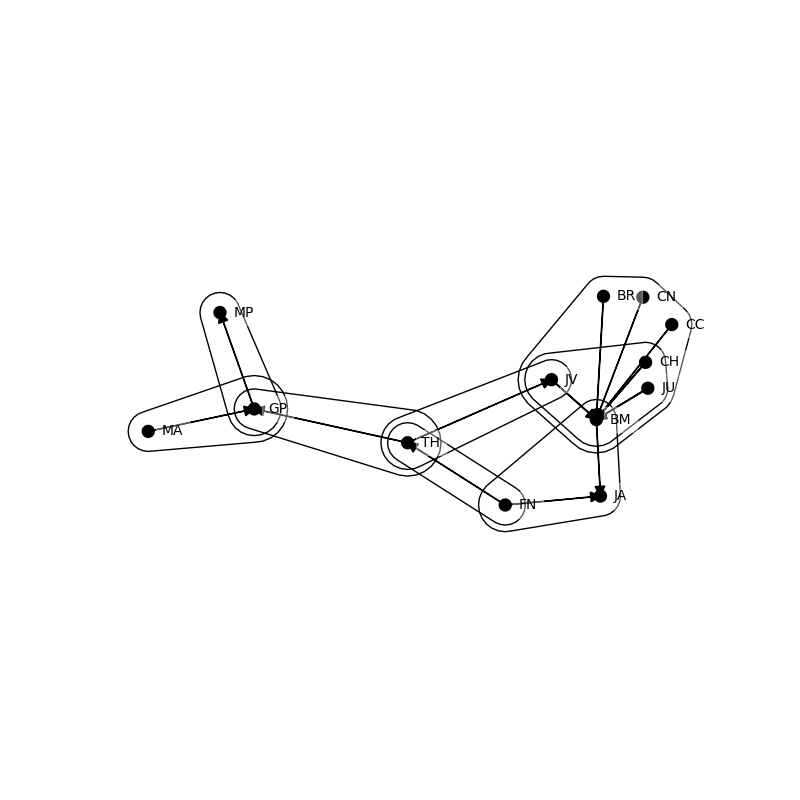

In [13]:
visualize_hg(H)

In [14]:
save_hg(H, "/tmp/hypergraph_example.png")

In [15]:
G,c=hg2g(H)

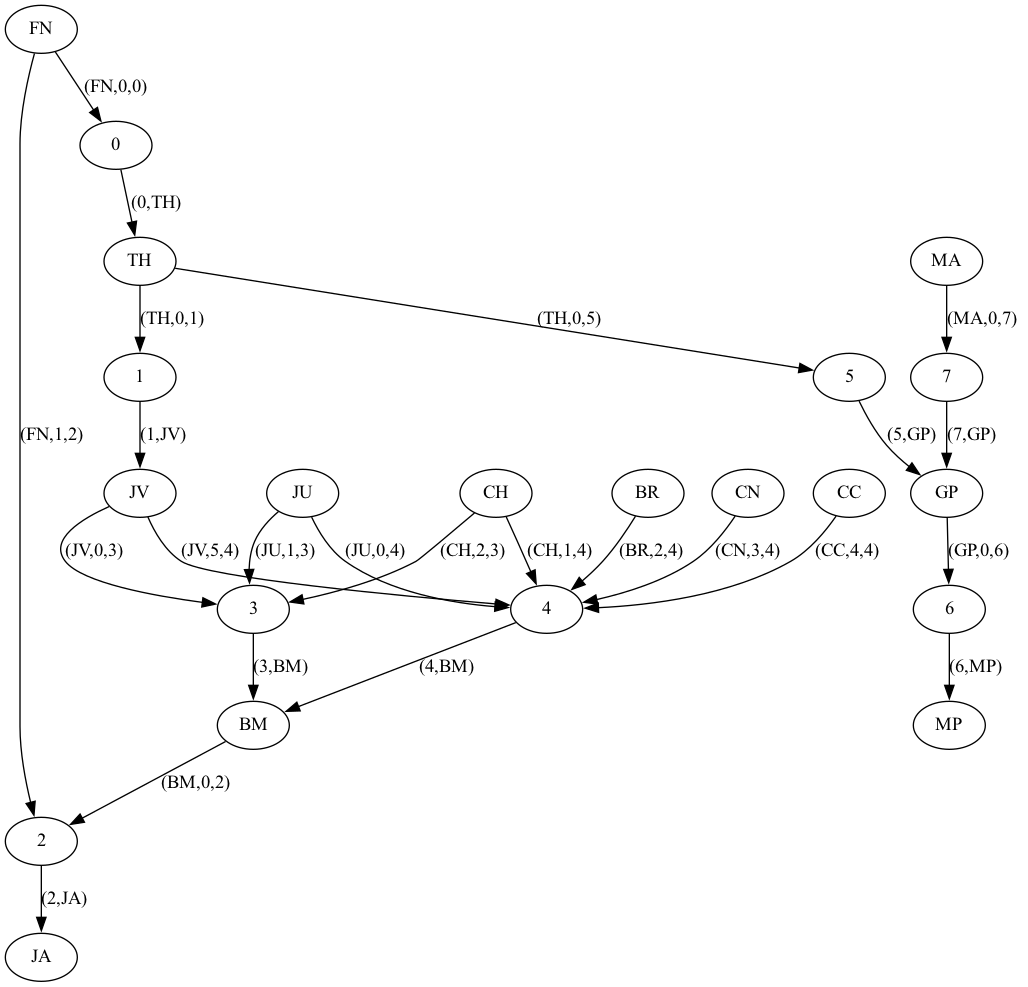

In [16]:
qf.graphs.visualize(G)

In [17]:
H = hnx.Hypergraph()
add_directed_hyperedge(H, ["A", "B"], "C1")
add_directed_hyperedge(H, ["A", "B"], "C2")

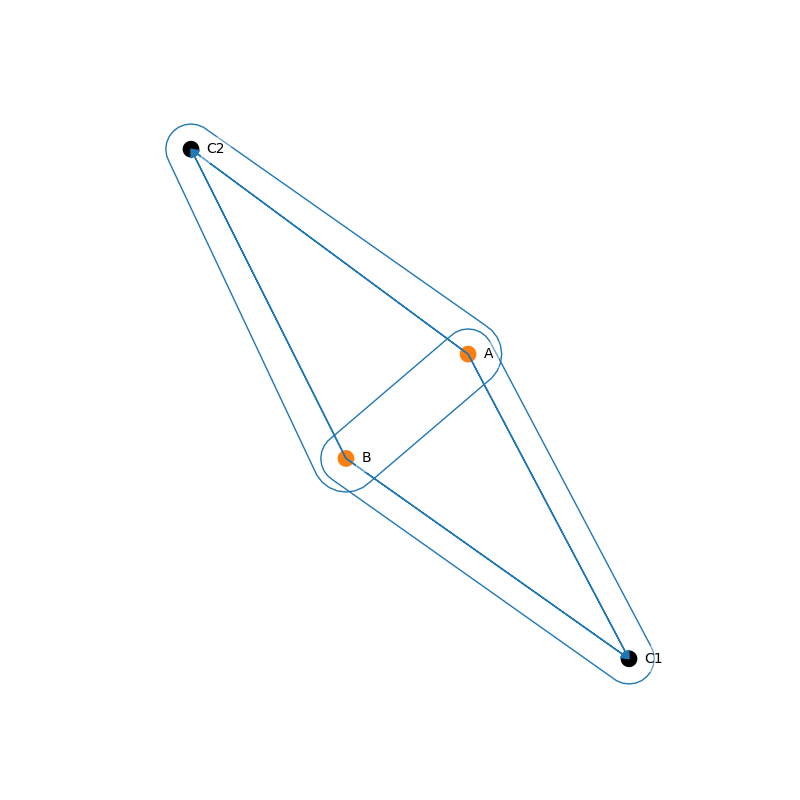

In [18]:
cc = hyper_cardon_crochemore(H)
visualize_hg(H, cc)

In [19]:
GG, dd = hg2g(H)

In [20]:
fd = qf.cc.cardon_crochemore(GG, starting_label=dd)

In [21]:
fd

{'A': 2, 'B': 2, 'C1': 0, 'C2': 0, 0: 1, 1: 1}

In [22]:
#############

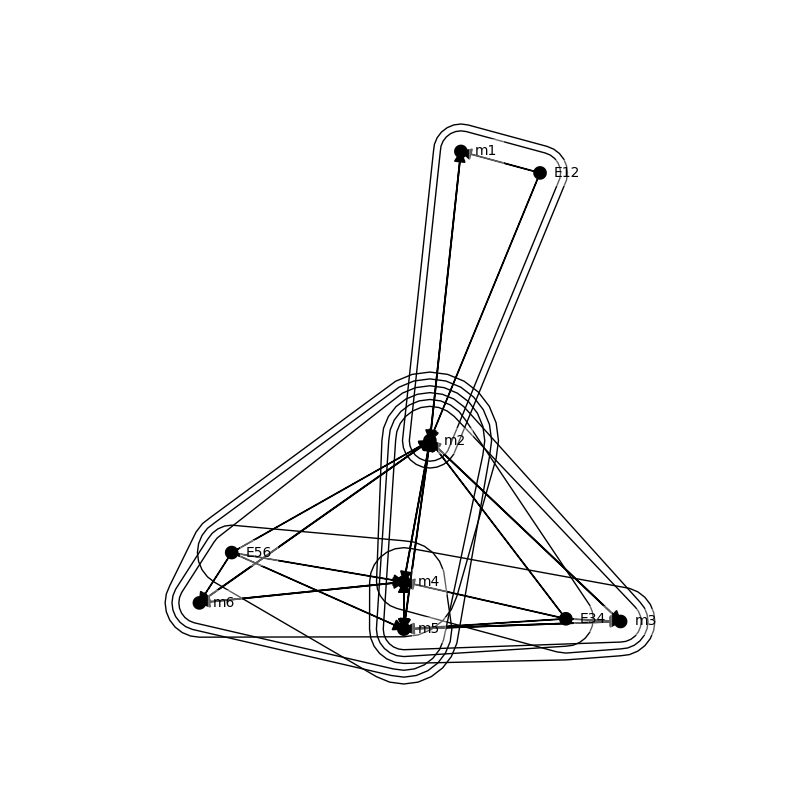

In [23]:
H = hnx.Hypergraph()
add_directed_hyperedge(H, ["m1", "E12"], "m2", name="R1")
add_directed_hyperedge(H, ["m2", "E12"], "m1", name="R2")
add_directed_hyperedge(H, ["m2", "m5", "E34"], "m3", name="R31")
add_directed_hyperedge(H, ["m2", "m5", "E34"], "m4", name="R32")
add_directed_hyperedge(H, ["m3", "m4", "E34"], "m2", name="R41")
add_directed_hyperedge(H, ["m3", "m4", "E34"], "m5", name="R42")
add_directed_hyperedge(H, ["m5", "m6", "E56"], "m2", name="R51")
add_directed_hyperedge(H, ["m5", "m6", "E56"], "m4", name="R52")
add_directed_hyperedge(H, ["m2", "m4", "E56"], "m5", name="R61")
add_directed_hyperedge(H, ["m2", "m4", "E56"], "m6", name="R62")
visualize_hg(H)

In [24]:
h=hyper_cardon_crochemore(H)
for x in set(h.values()):
    print([y for y in h.keys() if h[y]==x])

['R31', 'R32', 'R61', 'R62']
['R2']
['R41', 'R42', 'R51', 'R52']
['R1']
['m2']
['m5', 'm4']
['m3', 'm6']
['m1']
['E12', 'E34', 'E56']


In [25]:
H = read_hg_from_csv("/Users/boldi/Desktop/CSO.3.3.csv", 1000)
c = hyper_cardon_crochemore(H, nodes_only=True)

In [26]:
for v in set(c.values()):
    print([k for k in c.keys() if c[k]==v])
    print

['<https://cso.kmi.open.ac.uk/topics/decision_diagram>', '<https://cso.kmi.open.ac.uk/topics/decision_diagrams>']
['<https://cso.kmi.open.ac.uk/topics/sat-solving>']
['<https://cso.kmi.open.ac.uk/topics/sat_problems>']
['<https://cso.kmi.open.ac.uk/topics/sat>', '<https://cso.kmi.open.ac.uk/topics/boolean_satisfiability>']
['<https://cso.kmi.open.ac.uk/topics/sat_instances>', '<https://cso.kmi.open.ac.uk/topics/clause_learning>', '<https://cso.kmi.open.ac.uk/topics/propositional_satisfiability>', '<https://cso.kmi.open.ac.uk/topics/boolean_formulae>']
['<https://cso.kmi.open.ac.uk/topics/glass_lasers>']
['<https://cso.kmi.open.ac.uk/topics/manifold_learning>', '<https://cso.kmi.open.ac.uk/topics/repetition_rate>', '<https://cso.kmi.open.ac.uk/topics/fluences>', '<https://cso.kmi.open.ac.uk/topics/laser_induced>', '<https://cso.kmi.open.ac.uk/topics/business_intelligence_systems>']
['<https://cso.kmi.open.ac.uk/topics/pulse_repetition_rate>', '<https://cso.kmi.open.ac.uk/topics/pulse_en

In [27]:
H = read_hg_from_S("../../LaTeX/Data/ecoli_core_model.csv")

Ignoring value  -1.496
Ignoring value  -3.7478
Ignoring value  2
Ignoring value  59.81
Ignoring value  4.1182
Ignoring value  -59.81
Ignoring value  3.7478
Ignoring value  -0.361
Ignoring value  -0.0709
Ignoring value  -0.129
Ignoring value  -0.205
Ignoring value  -0.2557
Ignoring value  -4.9414
Ignoring value  2
Ignoring value  -59.81
Ignoring value  3
Ignoring value  59.81
Ignoring value  -2
Ignoring value  2
Ignoring value  2
Ignoring value  -4
Ignoring value  2
Ignoring value  2
Ignoring value  2
Ignoring value  -4
Ignoring value  2
Ignoring value  -2
Ignoring value  -2
Ignoring value  3
Ignoring value  -2
Ignoring value  -2
Ignoring value  -3.547
Ignoring value  3.547
Ignoring value  13.0279
Ignoring value  -13.0279
Ignoring value  -0.5
Ignoring value  -1.7867
Ignoring value  -0.5191
Ignoring value  59.81
Ignoring value  -2.8328
Ignoring value  -0.8977
ADK1  has no sources
Biomass_Ecoli_core  has no sources
EX_ac(e)  has no sources
EX_acald(e)  has no sources
EX_akg(e)  has no sou

In [28]:
m = hyper_cardon_crochemore(H)

In [29]:
for c in set(m.values()):
    print([k for k,v in m.items() if v==c])

['ATPS4r_0', 'ATPS4r_1']
['PYK_0', 'PYK_1', 'PYK_2']
['FRD7_0', 'FRD7_1']
['SUCCt2_2']
['ICL']
['2pg']
['acon-C']
['nh4(e)']
['pep']
['glc-D(e)']
['lac-D']
['acald']
['etoh']
['ac(e)']
['mal-L[e]']
['glx']
['6pgl']
['oaa']
['co2(e)']
['fru[e]']
['s7p']
['e4p']
['fdp']
['co2']
['lac-D(e)']
['acald[e]']
['PFK_0', 'PFK_1']
['ACKr_0', 'ACKr_1', 'PGK_0', 'PGK_1']
['PPCK_0', 'PPCK_1']
['dhap']
['pi(e)']
['for']
['etoh(e)']
['FORt2_0', 'FORt2_1']
['PGL_0', 'PGL_1']
['GAPD_0', 'GAPD_1', 'GAPD_2']
['GLUt2r_0', 'GLUt2r_1']
['GLUDy_0', 'GLUDy_1', 'GLUDy_2']
['SUCCt3_0', 'SUCCt3_1']
['ACt2r_0', 'ACt2r_1']
['MDH_0', 'MDH_1']
['AKGt2r_0', 'AKGt2r_1']
['G6PDH2r_0', 'G6PDH2r_1']
['ALCD2x_0', 'ALCD2x_1']
['LDH_D_0', 'LDH_D_1']
['D-LACt2_0', 'D-LACt2_1']
['PYRt2r_0', 'PYRt2r_1']
['ETOHt2r_0', 'ETOHt2r_1']
['succ']
['ru5p-D']
['q8']
['CS_0', 'CS_1', 'CS_2']
['MALS_0', 'MALS_1', 'MALS_2']
['PTAr_0', 'PTAr_1']
['fum(e)']
['akg(e)']
['nadp']
['h2o']
['glu-L']
['icit']
['ac', '3pg']
['o2(e)']
['ACONTa']
['CY

17/02/2023 14:47:38 [_visualize, line  153]: Could not use fdp/dot --- resorting to nx


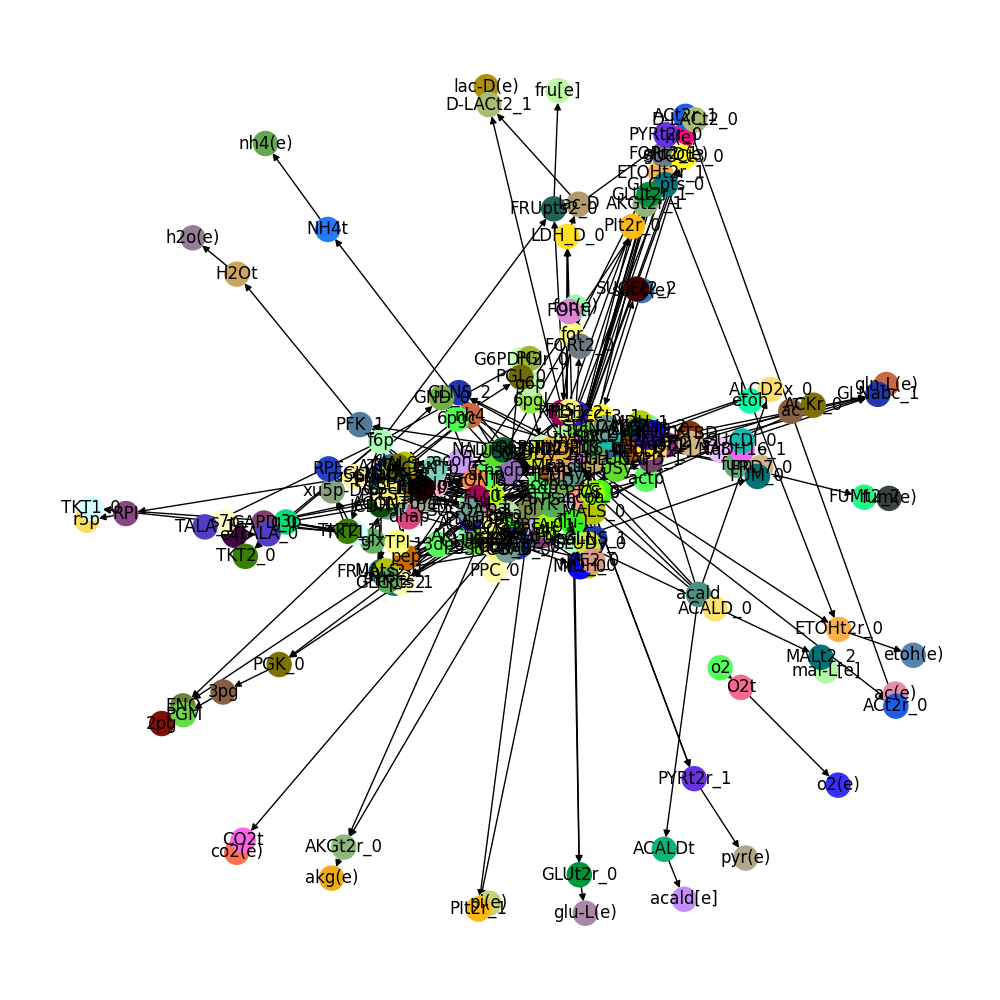

In [30]:
G, dd = hg2g(H)
qf.graphs.visualize(G, m)